In [3]:
from pmda.parallel import ParallelAnalysisBase
import numpy as np
from radii import types_radii
from MDAnalysis import Universe
import MDAnalysis as mda
import warnings
# import radii
warnings.filterwarnings("ignore")




class PackingDefect2:
    def __init__(self):
        pass

    def read_top(self, resname, topology_file):
        tails = []
        tails += ['C2%d' %i for i in range(2, 23)]
        tails += ['C3%d' %i for i in range(2, 23)]
        tails += ['H%dR' %i for i in range(2, 23)]
        tails += ['H%dS' %i for i in range(2, 23)]
        tails += ['H%dX' %i for i in range(2, 23)]
        tails += ['H%dY' %i for i in range(2, 23)]
        tails += ['H16Z', 'H18T', 'H91', 'H101', 'H18Z', 'H20T']
        TGglyc = ['O11', 'O21', 'O31', 'O12', 'O22', 'O32',
                  'C1', 'C2', 'C3', 'C11', 'C21', 'C31',
                  'HA', 'HB', 'HS', 'HX', 'HY']

        top = open(topology_file)
        startread = False
        output = {}
        for line in top:
            if line.startswith('!'):
                continue
            if line.startswith('RESI {}'.format(resname)):
                startread = True
            if startread and line.startswith('BOND'):
                startread = False
            if startread and line.startswith('ATOM'):
                sl = line.split()

                ### PL headgroup: -1
                ### PL acyl chains: 1
                ### TG glycerol: 2
                ### TG tail cahins: 3
                if resname != 'TRIO':
                    if sl[1] in tails:
                        acyl = 1
                    else:
                        acyl = -1
                else:
                    if sl[1] in TGglyc:
                        acyl = 2
                    else:
                        acyl = 3

                output[sl[1]] = [types_radii[sl[2]], acyl]
        return output


    def defect_size(self, matrices, nbins, bin_max, fname, prob=True):
        bins = np.linspace(0, bin_max, nbins)

        defects = []
        for matrix in matrices:
            graph = self._make_graph(matrix)
            visited = set([])
            for n in graph:
                if n not in visited:
                    defect_loc = self._dfs(graph, n)
                    visited = visited.union(defect_loc)
                    defects.append(len(defect_loc))

        hist, _ = np.histogram(defects, bins)
        hist = hist.astype(np.float64)
        binp = 0.5 * (_[1:] + _[:-1])

        if np.sum(hist) == 0:
            return

        if prob:
            hist /= np.sum(hist)
        
        np.savetxt(fname, np.transpose([binp, hist]), fmt="%8.5f")


    def _dfs(self, graph, start):
        visited, stack = set(), [start]
        while stack:
            vertex = stack.pop()
            if vertex not in visited:
                visited.add(vertex)
                stack.extend(graph[vertex] - visited)
        return visited


    def _make_graph(self, matrix):
        graph = {}
        xis, yis = matrix.shape

        for (xi, yi), value in np.ndenumerate(matrix):
            if value == 0:
                continue

            n = xi * yis + yi
            nlist = []

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    # 8-neighbors
                    x = divmod(xi + dx, xis)[1]
                    y = divmod(yi + dy, yis)[1]
                    if matrix[x, y] == 1:
                        ndn = x * yis + y
                        nlist.append(ndn)

                   # 4 neighbors
                   # if dx * dy == 0:
                   #     x = divmod(xi + dx, xis)[1]
                   #     y = divmod(yi + dy, yis)[1]
                   #     if matrix[x, y] == 1:
                   #         ndn = x * yis + y
                   #         nlist.append(ndn)

            graph[n] = set(nlist) - set([n])
        return graph


class PackingDefect2PMDA(ParallelAnalysisBase):
    def __init__(self, atomgroups, radii, start_frame=0, end_frame=None, nbins=600, bin_max=150, prefix='./', prob=True):
        u = atomgroups[0].universe
        self.N  = 3000 #The maximum number of defects
        self.dt = u.trajectory[0].dt
        self.dx = 1
        self.dy = 1
        self.radii = radii
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.nbins = nbins
        self.bin_max = bin_max
        self.prefix  = prefix
        self.prob    = prob
#         self.protein_atoms = u.select_atoms("protein")  # Add this line to select protein atoms
        super(PackingDefect2PMDA, self).__init__(u, atomgroups)

    def _prepare(self):
        pass

    def _single_frame(self, ts, atomgroups):
        ag = atomgroups[0]
        dim = ts.dimensions.copy()
        pbc = dim[0:3]
        print('time: {:.3f}    pbc: {:.3f} {:.3f} {:.3f}'.format(ts.time/1000, pbc[0], pbc[1], pbc[2]))
        pbc_xy0 = np.array([pbc[0],pbc[1],0])
        pbc_xyz = np.array([pbc[0],pbc[1],pbc[2]])
        aa = ag.universe.atoms
        aa.positions -= pbc_xy0 * np.floor(aa.positions / pbc_xyz)
        hz = np.average(ag.select_atoms('name P').positions[:,2])

        xarray = np.arange(0, pbc[0], self.dx)
        yarray = np.arange(0, pbc[1], self.dy)
        xx, yy = np.meshgrid(xarray, yarray)

        M = {}; M['up'] = np.zeros_like(xx); M['dw'] = np.zeros_like(xx)
        Z = {}; Z['up'] = np.zeros_like(xx); Z['dw'] = np.zeros_like(xx)
        Z['up'] += hz; Z['dw'] += hz

        zlim = {}
        zlim['up'] = np.max(ag.positions[:,2])
        zlim['dw'] = np.min(ag.positions[:,2])

        PL = {}
        PL['up'] = ag.select_atoms('name P and prop z > %f' %hz).center_of_mass()[2]
        PL['dw'] = ag.select_atoms('name P and prop z < %f' %hz).center_of_mass()[2]

        atoms = {}
        atoms['up'] = ag.select_atoms('prop z > %f' %(PL['up'] - 20))
        atoms['dw'] = ag.select_atoms('prop z < %f' %(PL['dw'] + 20))

        for l in ['up', 'dw']:
            for atom in atoms[l]:
                xatom, yatom, zatom = atom.position

                if l == 'up': assert zatom > PL[l] - 20, 'check Z pos'
                if l == 'dw': assert zatom < PL[l] + 20, 'check Z pos'

                radius, acyl = self.radii[atom.resname][atom.name]

                dxx =  xx - xatom
                dxx -= pbc[0] * np.around(dxx/pbc[0])

                dyy =  yy - yatom
                dyy -= pbc[1] * np.around(dyy/pbc[1])

                dist_meet = (np.sqrt(self.dx**2 + self.dy**2)/2 + radius)**2
                bAr = dxx ** 2 + dyy ** 2 < dist_meet

                if acyl == -1:
                    M[l][bAr] = acyl
                    continue

                else:
                    bAnP = M[l] >= 0

                    if l == 'up':
                        baZ = zatom > Z[l]
                    else:
                        baZ = zatom < Z[l]

                    bA = bAr & bAnP & baZ
                    M[l][bA] = acyl
                    Z[l][bA] = zatom

        return M['up'], M['dw'], PL['up']+5, PL['dw']-5, dim


    def _conclude(self):
        print("Concluding...")
        Mup = []; Mdw = []; zlimup = []; zlimdw = []; dim = []
        for r in self._results:
            for rr in r:
                Mup.append(rr[0])
                Mdw.append(rr[1])
                zlimup.append(rr[2])
                zlimdw.append(rr[3])
                dim.append(rr[4])

        N  = self.N
        df = Universe.empty(n_atoms = N,
                            n_residues = N,
                            atom_resindex = np.arange(N),
                            residue_segindex = [0] * N,
                            trajectory=True)

        df.add_TopologyAttr('resname', ['O'] * N)
        df.add_TopologyAttr('name',    ['O'] * N)
        df.add_TopologyAttr('resid', np.arange(N) + 1)

        nframes = len(dim)
        fac = np.zeros((nframes, N, 3))
        df.load_new(fac, order='fac')
        df.trajectory[0].dt = self.dt

        for i, ts in enumerate(df.trajectory):
            df.trajectory[i].dimensions = dim[i]

        defects = ['Deep', 'PLacyl', 'TGglyc', 'TGacyl']

        defect_uni = {}; defect_clu = {}
        for d in defects: defect_uni[d] = df.copy()
        for d in defects: defect_clu[d] = []
        defect_thr = {'Deep': 0,  'PLacyl': 1,  'TGglyc': 2,  'TGacyl': 3}

        for d in defects:
            for i, ts in enumerate(defect_uni[d].trajectory):
                num = 0

                bA  = (Mup[i] == defect_thr[d])
                defect_clu[d].append(bA.astype(int))
                ind = np.where(bA)
                xs  = ind[1]; ys = ind[0]

                for x1, y1 in zip(xs, ys):
                    pos = np.array([x1, y1, zlimup[i]])
                    defect_uni[d].atoms[num].position = pos
                    num += 1

                bA = (Mdw[i] == defect_thr[d])
                defect_clu[d].append(bA.astype(int))
                ind = np.where(bA)
                xs = ind[1]; ys = ind[0]

                for x1, y1 in zip(xs, ys):
                    pos = np.array([x1, y1, zlimdw[i]])
                    defect_uni[d].atoms[num].position = pos
                    num += 1

        ### DEFECT LOCALIZATION
        for d in defects:
            u = defect_uni[d]
            u.trajectory[-1]
            u.atoms.write(self.prefix + d + '.gro')
            with mda.Writer(self.prefix + d + '.xtc', u.atoms.n_atoms) as W:
                for ts in u.trajectory:
                    W.write(u.atoms)

        ### DEFECT CLUSTER
        PD = PackingDefect2()
        for d in defects:
            PD.defect_size(defect_clu[d],
                    fname=self.prefix + d + '.dat',
                    nbins=self.nbins,
                    bin_max=self.bin_max,
                    prob=self.prob)

In [51]:
if __name__ == '__main__':

    u = mda.Universe('trajs/gro.gro', 'trajs/skipc.xtc')
    pd = PackingDefect2()

    lipid = 'top/top_all36_lipid.rtf'
    TRIO  = 'top/TRIO.rtf'
    SAPI  = 'top/toppar_all36_lipid_inositol.str'

    radii = {'POPC': pd.read_top('POPC', lipid),
             'DOPE': pd.read_top('DOPE', lipid),
             'SAPI': pd.read_top('SAPI', SAPI),
             'TRIO': pd.read_top('TRIO', TRIO)}

    MEMB = u.select_atoms('resname POPC DOPE SAPI TRIO')
    pdPMDA = PackingDefect2PMDA([MEMB], radii)
    pdPMDA.run(n_jobs=12)

/home/jaybraun/miniconda3/lib/python3.9/site-packages/pmda/parallel.py:440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(res), np.asarray(times_io), np.asarray(
/home/jaybraun/miniconda3/lib/python3.9/site-packages/pmda/parallel.py:440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(res), np.asarray(times_io), np.asarray(


time: 400.000    pbc: 94.464 94.464 152.228
time: 100.000    pbc: 93.945 93.945 153.619
time: 1100.000    pbc: 96.242 96.242 146.554
time: 900.000    pbc: 92.453 92.453 158.906
time: 700.000    pbc: 94.979 94.979 150.141
time: 300.000    pbc: 94.055 94.055 153.014
time: 500.000    pbc: 94.206 94.206 152.708
time: 1000.000    pbc: 93.689 93.689 154.678
time: 800.000    pbc: 94.191 94.191 153.037
time: 600.000    pbc: 94.445 94.445 152.158
time: 0.000    pbc: 91.695 91.695 203.123
time: 200.000    pbc: 94.589 94.589 151.746
Concluding...


In [5]:

import matplotlib.pyplot as plt

def _dfs(graph, start):
    visited, stack = set(), [start]
    while stack:
        vertex = stack.pop()
        if vertex not in visited:
            visited.add(vertex)
            stack.extend(graph[vertex] - visited)
    return visited


def _make_graph(matrix):
    graph = {}
    xis, yis = matrix.shape

    for (xi, yi), value in np.ndenumerate(matrix):
        if value == 0:
            continue

        n = xi * yis + yi
        nlist = []

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                # 8-neighbors
                x = divmod(xi + dx, xis)[1]
                y = divmod(yi + dy, yis)[1]
                if matrix[x, y] == 1:
                    ndn = x * yis + y
                    nlist.append(ndn)

        graph[n] = set(nlist) - set([n])
    return graph

In [52]:
u = mda.Universe('PLacyl.gro', 'PLacyl.xtc')
u2 = mda.Universe('TGacyl.gro', 'TGacyl.xtc')
u3 = mda.Universe('TGglyc.gro', 'TGglyc.xtc')

In [55]:
def calculate_defects(u):
    defects = []

    u.trajectory[9]
    ag = u.select_atoms('prop z > 0')
    hz = np.average(ag.positions[:,2])
    agup = u.select_atoms('prop z > %f' %hz)
    agdw = u.select_atoms('prop z < %f' %hz)

    plt.scatter(agup.positions[:,0], agup.positions[:,1])

    plt.axis('square')
    plt.ylim(0,100)
    plt.xlim(0,100)

    xarray = np.arange(0, u.dimensions[0], 1)
    yarray = np.arange(0, u.dimensions[1], 1)
    xx, yy = np.meshgrid(xarray, yarray)
    Mup = np.zeros_like(xx)
    Mdw = np.zeros_like(xx)

    xind = agup.positions[:,0].astype(np.int64)
    yind = agup.positions[:,1].astype(np.int64)

    Mup[xind, yind] = 1

    graph = _make_graph(Mup)
    visited = set([])
    for n in graph:
        if n not in visited:
            defect_loc = _dfs(graph, n)
            visited = visited.union(defect_loc)
            defects.append(len(defect_loc))
            
    return defects



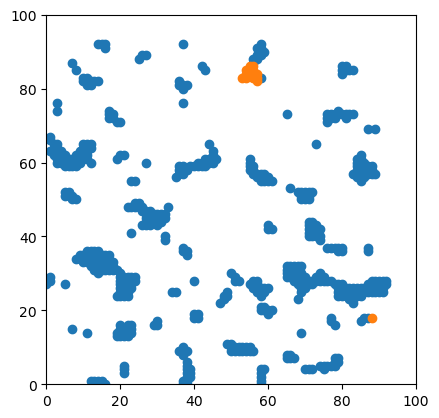

In [56]:
defects_PLacyl = calculate_defects(u)
defects_TGacyl = calculate_defects(u2)
defects_TGglyc = calculate_defects(u3)

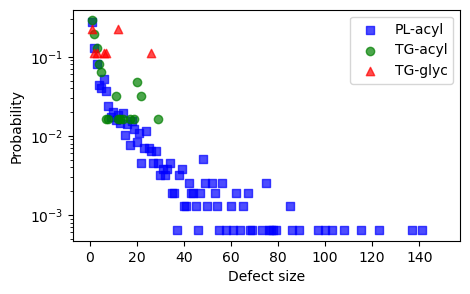

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
d = np.loadtxt('TGacyl.dat')
d2 = np.loadtxt('TGglyc.dat')
d3 = np.loadtxt('PLacyl.dat')

# Create the scatter plot
plt.figure(figsize=(5, 3))
plt.scatter(d3[:, 0], d3[:, 1], color='blue',marker='s', label='PL-acyl', alpha=0.7)
plt.scatter(d[:, 0], d[:, 1], color='green',marker='o', label='TG-acyl', alpha=0.7)
plt.scatter(d2[:, 0], d2[:, 1], color='red',marker='^', label='TG-glyc', alpha=0.7)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Defect size')
plt.ylabel('Probability')

plt.legend()

# Save the plot
# plt.savefig('scatter_plot.png')


In [58]:
xlim = 0
ylim = 1e-5
def fitting(dat):
    x = dat[:, 0]
    y = dat[:, 1]
    valid_mask = (x > xlim) & (y > ylim) & (y > 0)
    newx = x[valid_mask]
    newy = y[valid_mask]

    if len(newx) > 0 and len(newy) > 0:
        a, b = np.polyfit(newx, np.log(newy), 1)
        return a, b, x[y > 0], y[y > 0]
    else:
        return None, None, [], []

def calculate_defect_constants(defects):
    h, bin_edges = np.histogram(defects, bins=np.linspace(0, 150, 600))
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    data = np.column_stack((bin_centers, h))
    
    a, b, plotx, ploty = fitting(data)
    if a is not None:
        return -1 / a
    else:
        return None


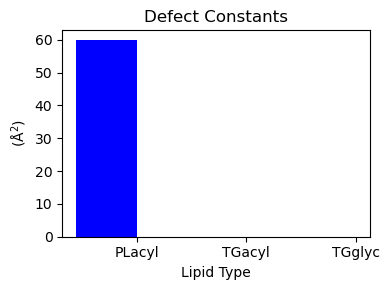

In [60]:

# Your calculated constants
PLacyl_constant = calculate_defect_constants(defects_PLacyl) or 0
TGacyl_constant = calculate_defect_constants(defects_TGacyl) or 0
TGglyc_constant = calculate_defect_constants(defects_TGglyc) or 0

# Bar plot setup
labels = ['PLacyl', 'TGacyl', 'TGglyc']
constants = [PLacyl_constant, TGacyl_constant, TGglyc_constant]

x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

fig, ax = plt.subplots(figsize=(4, 3))
# Specify colors for each bar here
colors = ['blue', 'green', 'red']
rects1 = ax.bar(x - width/2, constants, width, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Lipid Type')
ax.set_ylabel('($\mathregular{\AA^2}$)')
ax.set_title('Defect Constants')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# plt.ylim(0,50)
fig.tight_layout()
# plt.savefig('constants.png',dpi=400)

plt.show()
